In [2]:
!pip install yfinance


  Obtaining dependency information for yfinance from https://files.pythonhosted.org/packages/e9/43/93ea65227c938a0a4a8925d7f054b050ea743044b887170da9eca210635a/yfinance-0.2.28-py2.py3-none-any.whl.metadata
     ---------------------------------------- 0.0/112.2 kB ? eta -:--:--
     ---------------------------------------- 112.2/112.2 kB ? eta 0:00:00
   ---------------------------------------- 0.0/65.3 kB ? eta -:--:--
   ---------------------------------------- 65.3/65.3 kB 3.7 MB/s eta 0:00:00


In [4]:
!pip install tensorflow

  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/9e/b8/ed5f794359d05cd0bffb894c6418da87b93016ee17b669d55c45d1bd5d5b/tensorflow-2.13.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for tensorflow-intel==2.13.0 from https://files.pythonhosted.org/packages/2f/2f/3c84f675931ce3bcbc7e23acbba1e5d7f05ce769adab48322de57a9f5928/tensorflow_intel-2.13.0-cp311-cp311-win_amd64.whl.metadata
  Using cached absl_py-1.4.0-py3-none-any.whl (126 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Obtaining dependency information for flatbuffers>=23.1.21 from https://files.pythonhosted.org/packages/6f/12/d5c79ee252793ffe845d58a913197bfa02ae9a0b5c9bc3dc4b58d477b9e7/flatbuffers-23.5.26-py2.py3-none-any.whl.metadata
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Obtaining dependency information for libclang>=13.0.0 from https://files.pythonhosted.org/packages/

[*********************100%%**********************]  1 of 1 completed


C:\Users\avisa\AppData\Local\Temp\ipykernel_6636\493579286.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Close'] = scaler.fit_transform(data['Close'].values.reshape(-1, 1))


Epoch 1/50
37/37 [==============================] - 11s 25ms/step - loss: 0.0030
Epoch 2/50
37/37 [==============================] - 1s 26ms/step - loss: 8.0108e-05
Epoch 3/50
37/37 [==============================] - 1s 27ms/step - loss: 4.5036e-05
Epoch 4/50
37/37 [==============================] - 1s 26ms/step - loss: 4.1809e-05
Epoch 5/50
37/37 [==============================] - 1s 38ms/step - loss: 4.0813e-05
Epoch 6/50
37/37 [==============================] - 1s 27ms/step - loss: 4.0679e-05
Epoch 7/50
37/37 [==============================] - 1s 29ms/step - loss: 4.1962e-05
Epoch 8/50
37/37 [==============================] - 1s 26ms/step - loss: 4.0172e-05
Epoch 9/50
37/37 [==============================] - 1s 20ms/step - loss: 4.1739e-05
Epoch 10/50
37/37 [==============================] - 1s 19ms/step - loss: 3.9022e-05
Epoch 11/50
37/37 [==============================] - 1s 19ms/step - loss: 3.9310e-05
Epoch 12/50
37/37 [==============================] - 1s 20ms/step - loss: 4.0

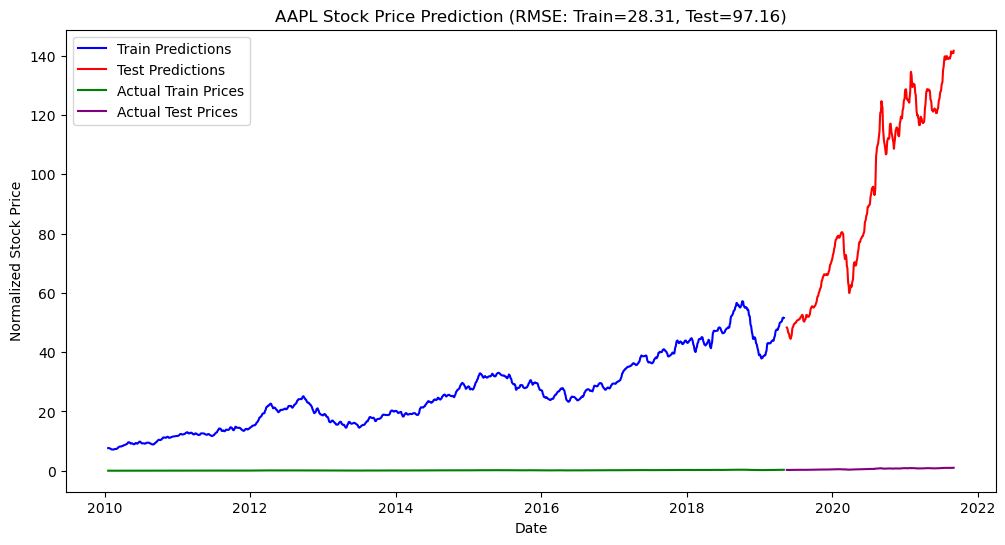

In [7]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Set the random seed for reproducibility
tf.random.set_seed(42)

# Define the stock symbol and download historical data
stock_symbol = "AAPL"
start_date = "2010-01-01"
end_date = "2021-09-01"

# Download historical stock price data using yfinance
data = yf.download(stock_symbol, start=start_date, end=end_date)

# Extract the 'Close' prices for prediction
data = data[['Close']]

# Normalize the data using Min-Max scaling
scaler = MinMaxScaler()
data['Close'] = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

# Split the data into training and testing sets
train_size = int(len(data) * 0.80)
train_data = data[:train_size]
test_data = data[train_size:]

# Create sequences for training and testing data
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 10  # You can adjust this sequence length
X_train, y_train = create_sequences(train_data.values, seq_length)
X_test, y_test = create_sequences(test_data.values, seq_length)

# Ensure that y_train and y_test have the same length as X_train and X_test
y_train = y_train.squeeze()
y_test = y_test.squeeze()

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(seq_length, 1), return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=64, verbose=1)

# Make predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Inverse transform the predictions to get actual prices
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)

# Calculate RMSE for training and testing data
train_rmse = np.sqrt(mean_squared_error(train_data[seq_length:], train_predictions))
test_rmse = np.sqrt(mean_squared_error(test_data[seq_length:], test_predictions))

# Plot the results
plt.figure(figsize=(12, 6))
train_range = range(seq_length, train_size)
test_range = range(train_size + seq_length, len(data))

plt.plot(data.index[train_range], train_predictions, label='Train Predictions', color='blue')
plt.plot(data.index[test_range], test_predictions, label='Test Predictions', color='red')
plt.plot(data.index[train_range], data['Close'][seq_length:train_size], label='Actual Train Prices', color='green')
plt.plot(data.index[test_range], data['Close'][train_size + seq_length:], label='Actual Test Prices', color='purple')

plt.legend()
plt.title(f'{stock_symbol} Stock Price Prediction (RMSE: Train={train_rmse:.2f}, Test={test_rmse:.2f})')
plt.xlabel('Date')
plt.ylabel('Normalized Stock Price')
plt.show()